Preprocessing and Visualization of the data 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import snowflake.connector

In [ ]:
sf_account = "###"
sf_user = "####"
sf_password = "####"
sf_database = "EXCHANGE_RATES_SL"
sf_schema = "DBO"
sf_warehouse = "COMPUTE_WH"
sf_role = "ACCOUNTADMIN"


In [3]:
conn = snowflake.connector.connect(
    user=sf_user,
    password=sf_password,
    account=sf_account,
    warehouse=sf_warehouse,
    database=sf_database,
    schema=sf_schema,
    role=sf_role
)

In [4]:
def load_table(table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, conn)

exchange_df = load_table("EXCHANGE_RATES_SL")
econ_df = load_table("SL_ECONOMIC_DATA")
tourism_df = load_table("TOURSIM_SL")

print("✅ Tables loaded.")

C:\Users\vimuthu_hone\AppData\Local\Temp\ipykernel_9872\59334643.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


✅ Tables loaded.


In [6]:
from datetime import datetime

tourism_df["DATE"] = pd.to_datetime(tourism_df["DATE"])
econ_df["DATE"] = pd.to_datetime(econ_df["DATE"])
exchange_df["DATE"] = pd.to_datetime(exchange_df["DATE"])

final_df = pd.merge(exchange_df, tourism_df, on="DATE", how="left")
final_df = pd.merge(final_df, econ_df, on="DATE", how="left")

final_df = final_df.dropna(thresh=final_df.shape[1] // 2)

print("🧹 Data cleaned and merged.")
final_df.head()


🧹 Data cleaned and merged.


,DATE,USD,RUB,INR,GBP,EUR,CNY,AUD,TOURISM_SL,SRI_LANKA_GDP_USD_BILLIONS_USD,PER_CAPITA_USD,MERCHANDISE_IMPORTS_MILLIONS_USD,MERCHANDISE_EXPORTS_MILLIONS_USD,FOREIGN_INVESTMENTS_BILLIONS_USD,LABOUR_MIGRATION_SL,INFLATION_RATE_PCR,ANNUAL_CHANGE_PCR,GDP_GROWTH_PCT,GDP_PER_CAPITA_USD
11,2025-02-28,295.4981,3.3694,3.3839,372.0764,307.0225,40.5637,183.8441,14042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2025-02-27,295.7164,3.4059,3.3947,374.5100,309.7481,40.6936,186.5823,10593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2025-02-25,295.7490,3.3704,3.4101,373.5310,309.6344,40.7632,187.7563,935.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2025-02-24,295.8829,3.3433,3.4157,375.2535,311.2984,40.8173,188.7141,6732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2025-02-21,296.4754,3.3434,3.4256,375.3972,311.1065,40.8934,189.7294,11163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


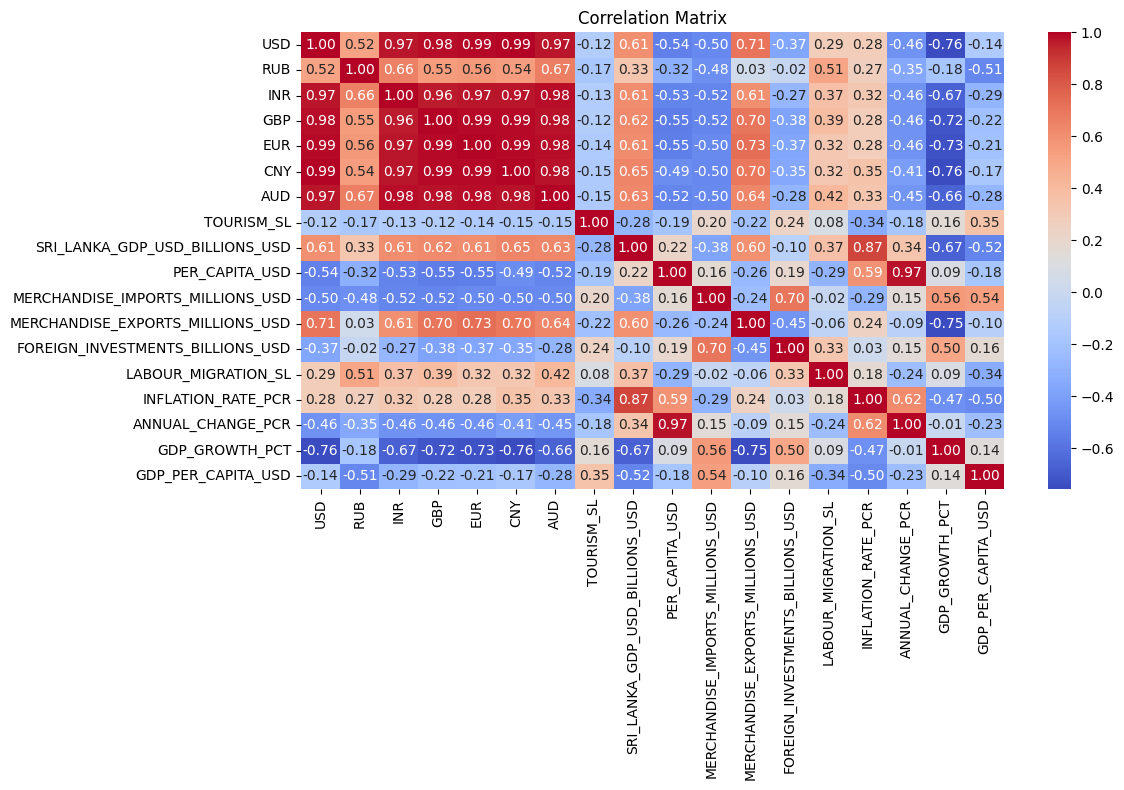

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


🌟 Top Features Predicting USD Exchange Rate:


INR                                 0.360349
CNY                                 0.245332
EUR                                 0.134027
GBP                                 0.096851
MERCHANDISE_EXPORTS_MILLIONS_USD    0.077422
AUD                                 0.043530
RUB                                 0.022748
GDP_PER_CAPITA_USD                  0.008673
LABOUR_MIGRATION_SL                 0.006368
GDP_GROWTH_PCT                      0.001783
dtype: float64

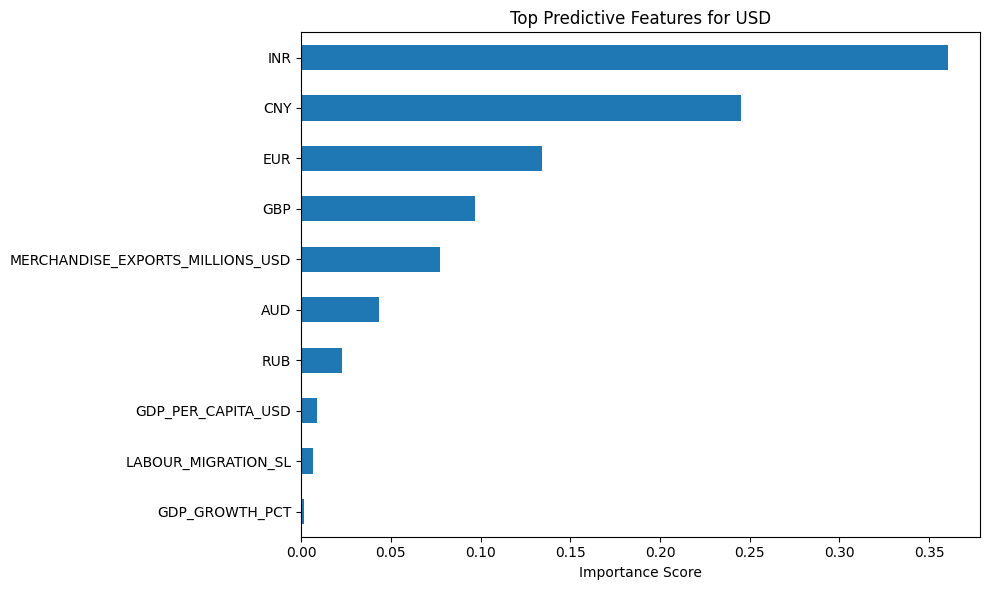

In [ ]:
target_col = "USD" 

df_clean = final_df.dropna(subset=[target_col])
X = df_clean.drop(columns=["DATE", target_col])
y = df_clean[target_col]

for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print(f"\n🌟 Top Features Predicting {target_col} Exchange Rate:")
display(importances.head(10))

importances.head(10).plot(kind="barh", figsize=(10, 6))
plt.gca().invert_yaxis()
plt.title(f"Top Predictive Features for {target_col}")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()



🔍 Analyzing feature importance for: USD
🌟 Top features for USD:


SRI_LANKA_GDP_USD_BILLIONS_USD      0.756468
ANNUAL_CHANGE_PCR                   0.060064
PER_CAPITA_USD                      0.049750
MERCHANDISE_EXPORTS_MILLIONS_USD    0.048994
LABOUR_MIGRATION_SL                 0.032054
GDP_PER_CAPITA_USD                  0.022712
MERCHANDISE_IMPORTS_MILLIONS_USD    0.018864
INFLATION_RATE_PCR                  0.006346
GDP_GROWTH_PCT                      0.002768
TOURISM_SL                          0.001027
dtype: float64

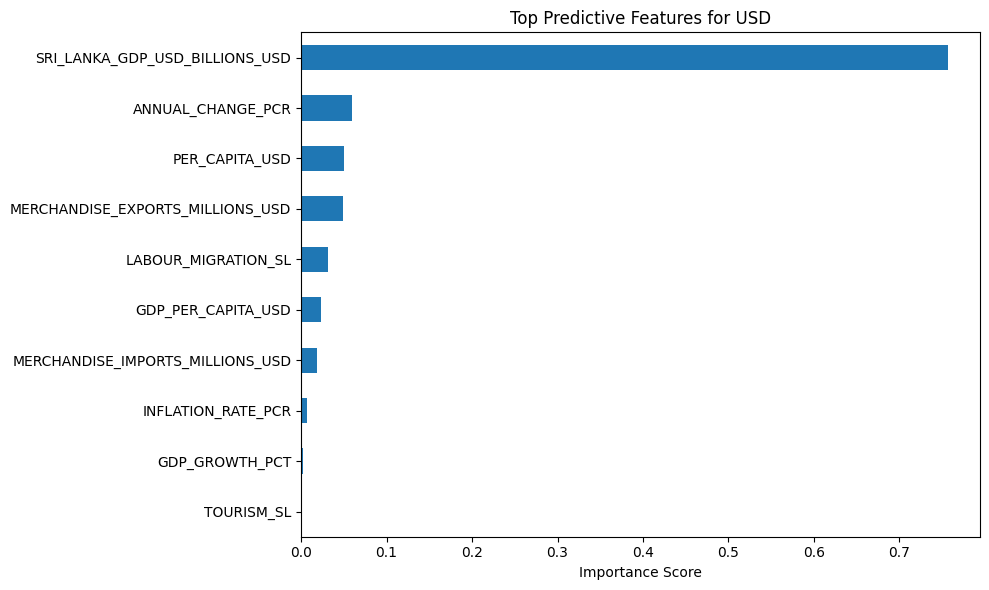


🔍 Analyzing feature importance for: EUR
🌟 Top features for EUR:


SRI_LANKA_GDP_USD_BILLIONS_USD      0.779901
ANNUAL_CHANGE_PCR                   0.058650
PER_CAPITA_USD                      0.048383
MERCHANDISE_EXPORTS_MILLIONS_USD    0.043396
LABOUR_MIGRATION_SL                 0.027330
MERCHANDISE_IMPORTS_MILLIONS_USD    0.022732
GDP_PER_CAPITA_USD                  0.007784
INFLATION_RATE_PCR                  0.005252
TOURISM_SL                          0.002870
GDP_GROWTH_PCT                      0.002313
dtype: float64

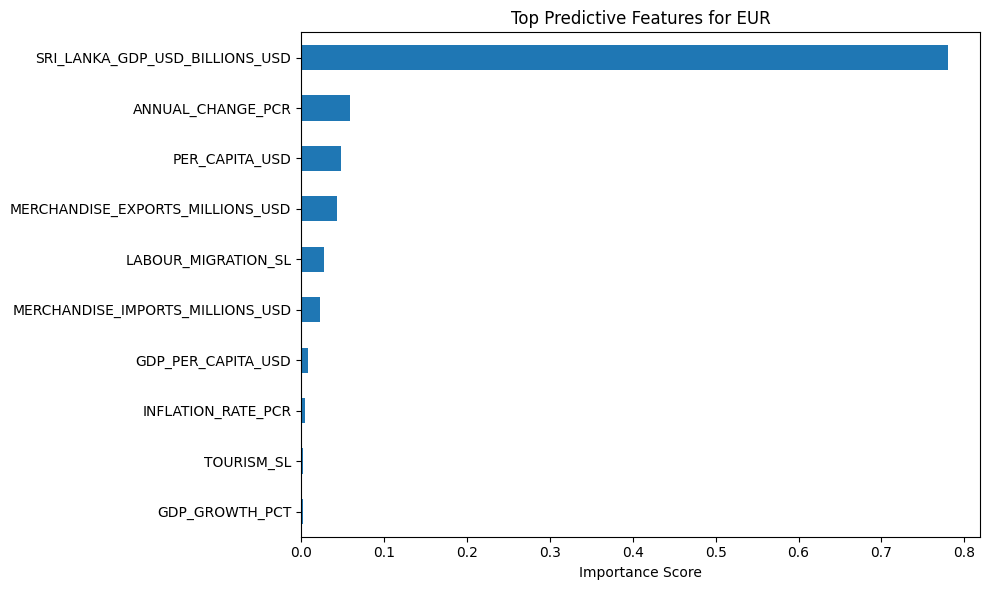


🔍 Analyzing feature importance for: GBP
🌟 Top features for GBP:


SRI_LANKA_GDP_USD_BILLIONS_USD      0.808487
ANNUAL_CHANGE_PCR                   0.054984
PER_CAPITA_USD                      0.037543
MERCHANDISE_EXPORTS_MILLIONS_USD    0.029194
LABOUR_MIGRATION_SL                 0.025390
MERCHANDISE_IMPORTS_MILLIONS_USD    0.016719
INFLATION_RATE_PCR                  0.011468
GDP_PER_CAPITA_USD                  0.009538
GDP_GROWTH_PCT                      0.003458
TOURISM_SL                          0.002107
dtype: float64

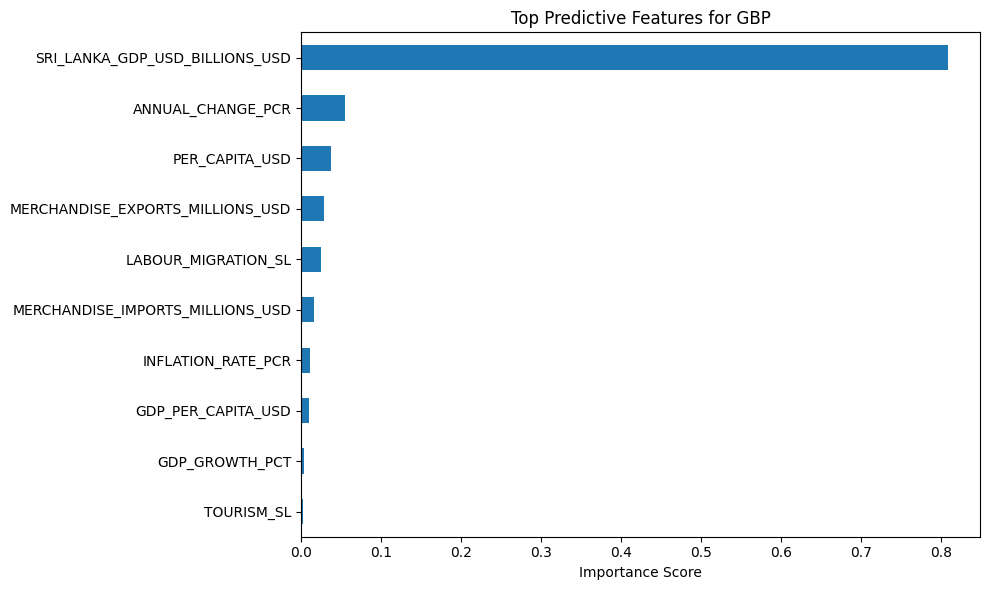


🔍 Analyzing feature importance for: INR
🌟 Top features for INR:


SRI_LANKA_GDP_USD_BILLIONS_USD      0.737694
MERCHANDISE_IMPORTS_MILLIONS_USD    0.119568
INFLATION_RATE_PCR                  0.037237
GDP_PER_CAPITA_USD                  0.030162
MERCHANDISE_EXPORTS_MILLIONS_USD    0.022874
PER_CAPITA_USD                      0.017582
ANNUAL_CHANGE_PCR                   0.012065
LABOUR_MIGRATION_SL                 0.011649
FOREIGN_INVESTMENTS_BILLIONS_USD    0.006469
TOURISM_SL                          0.003065
dtype: float64

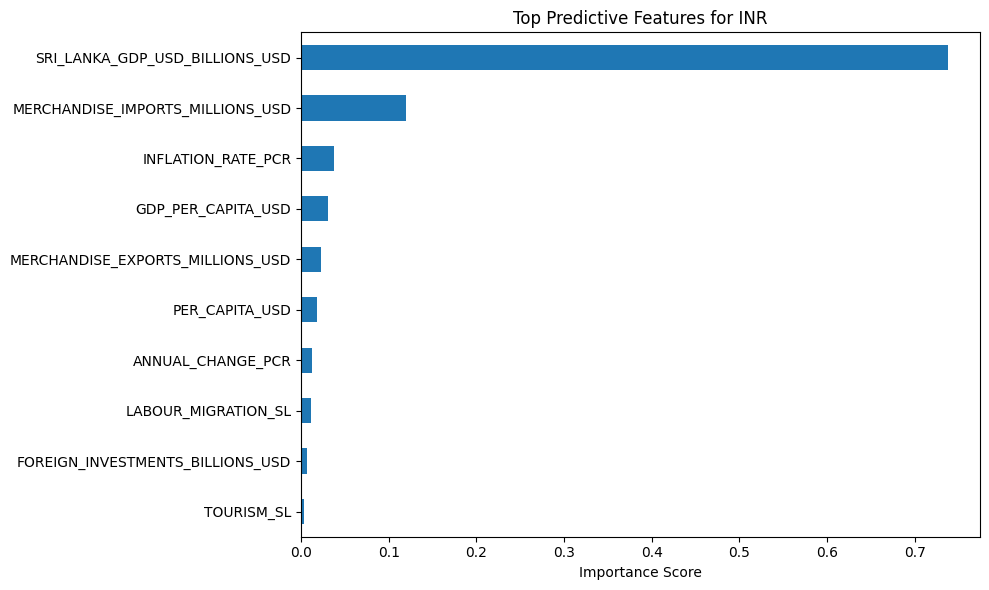


🔍 Analyzing feature importance for: RUB
🌟 Top features for RUB:


LABOUR_MIGRATION_SL                 0.518843
MERCHANDISE_IMPORTS_MILLIONS_USD    0.256526
INFLATION_RATE_PCR                  0.070480
GDP_GROWTH_PCT                      0.043175
MERCHANDISE_EXPORTS_MILLIONS_USD    0.039146
GDP_PER_CAPITA_USD                  0.021352
ANNUAL_CHANGE_PCR                   0.015696
PER_CAPITA_USD                      0.013297
TOURISM_SL                          0.010332
FOREIGN_INVESTMENTS_BILLIONS_USD    0.009064
dtype: float64

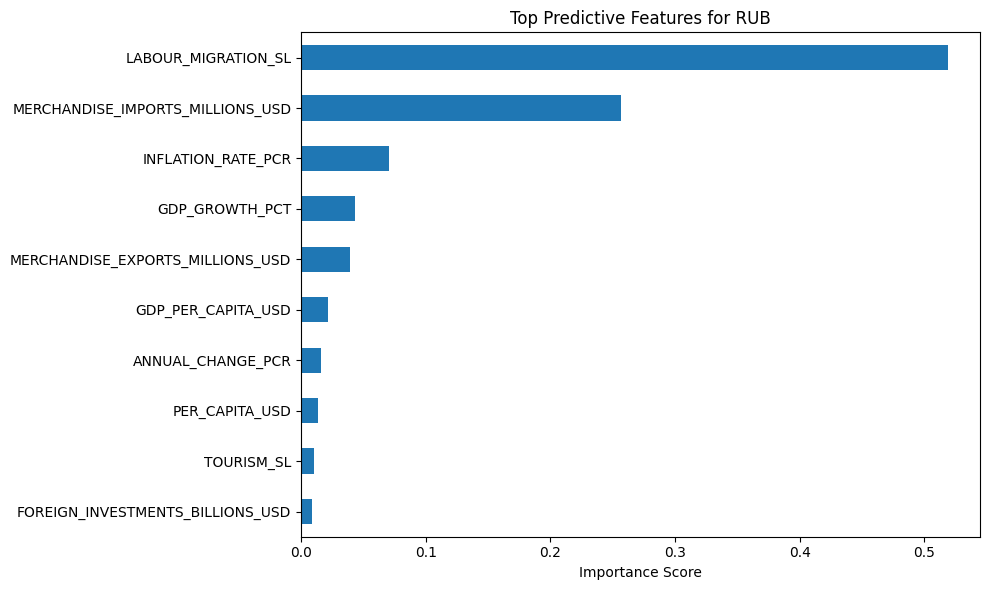


🔍 Analyzing feature importance for: CNY
🌟 Top features for CNY:


SRI_LANKA_GDP_USD_BILLIONS_USD      0.783443
MERCHANDISE_IMPORTS_MILLIONS_USD    0.082111
MERCHANDISE_EXPORTS_MILLIONS_USD    0.032191
INFLATION_RATE_PCR                  0.026115
LABOUR_MIGRATION_SL                 0.024439
GDP_PER_CAPITA_USD                  0.024116
ANNUAL_CHANGE_PCR                   0.012289
GDP_GROWTH_PCT                      0.008918
PER_CAPITA_USD                      0.004359
TOURISM_SL                          0.001407
dtype: float64

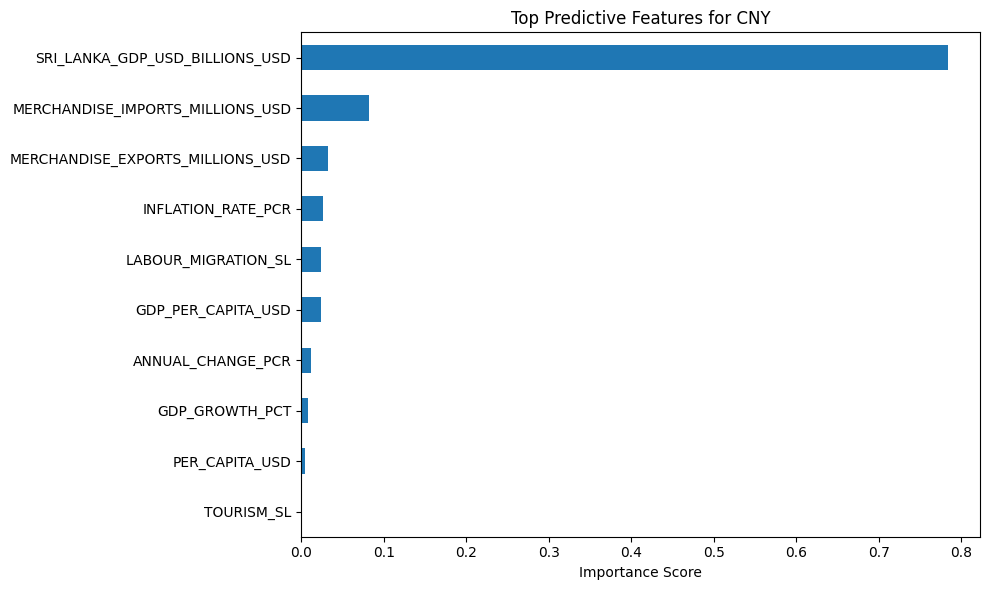


🔍 Analyzing feature importance for: AUD
🌟 Top features for AUD:


SRI_LANKA_GDP_USD_BILLIONS_USD      0.763588
MERCHANDISE_IMPORTS_MILLIONS_USD    0.107925
INFLATION_RATE_PCR                  0.034128
GDP_PER_CAPITA_USD                  0.030088
MERCHANDISE_EXPORTS_MILLIONS_USD    0.016678
ANNUAL_CHANGE_PCR                   0.014250
PER_CAPITA_USD                      0.013842
LABOUR_MIGRATION_SL                 0.008023
GDP_GROWTH_PCT                      0.004232
FOREIGN_INVESTMENTS_BILLIONS_USD    0.003771
dtype: float64

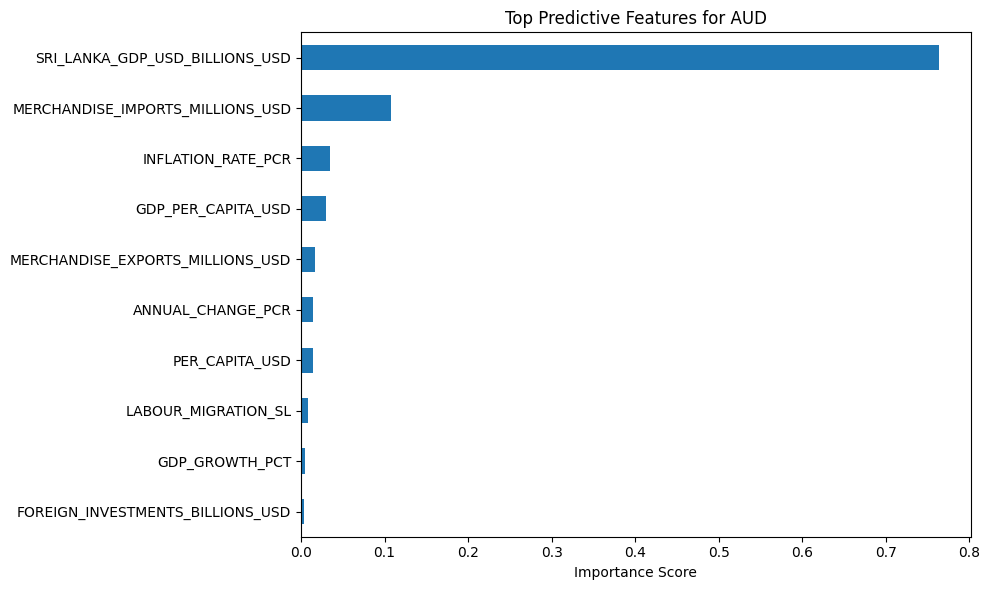

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

exchange_rate_columns = ["USD", "EUR", "GBP", "INR", "RUB", "CNY", "AUD"]

for target_col in exchange_rate_columns:
    print(f"\n🔍 Analyzing feature importance for: {target_col}")

    df_clean = final_df.dropna(subset=[target_col])

    X = df_clean.drop(columns=["DATE"] + exchange_rate_columns)
    y = df_clean[target_col]

    for col in X.select_dtypes(include="object").columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)

    print(f"🌟 Top features for {target_col}:")
    display(importances.head(10))

    importances.head(10).plot(kind="barh", figsize=(10, 6))
    plt.gca().invert_yaxis()
    plt.title(f"Top Predictive Features for {target_col}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

exchange_rate_columns = ["USD", "EUR", "GBP", "INR", "RUB", "CNY", "AUD"]

top_features_per_currency = {}

for target_col in exchange_rate_columns:
    print(f"\n Processing: {target_col}")

    df_clean = final_df.dropna(subset=[target_col])

    X = df_clean.drop(columns=["DATE"] + exchange_rate_columns)
    y = df_clean[target_col]

    for col in X.select_dtypes(include="object").columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    importances = pd.Series(model.feature_importances_, index=X.columns)
    top_columns = importances.sort_values(ascending=False).head(5).index.tolist()

    top_features_per_currency[target_col] = top_columns

print("\n Top Features per Exchange Rate Currency:")
for currency, columns in top_features_per_currency.items():
    print(f"{currency}: {columns}")



 Processing: USD

 Processing: EUR

 Processing: GBP

 Processing: INR

 Processing: RUB

 Processing: CNY

 Processing: AUD

 Top Features per Exchange Rate Currency:
USD: ['SRI_LANKA_GDP_USD_BILLIONS_USD', 'ANNUAL_CHANGE_PCR', 'PER_CAPITA_USD', 'MERCHANDISE_EXPORTS_MILLIONS_USD', 'LABOUR_MIGRATION_SL']
EUR: ['SRI_LANKA_GDP_USD_BILLIONS_USD', 'ANNUAL_CHANGE_PCR', 'PER_CAPITA_USD', 'MERCHANDISE_EXPORTS_MILLIONS_USD', 'LABOUR_MIGRATION_SL']
GBP: ['SRI_LANKA_GDP_USD_BILLIONS_USD', 'ANNUAL_CHANGE_PCR', 'PER_CAPITA_USD', 'MERCHANDISE_EXPORTS_MILLIONS_USD', 'LABOUR_MIGRATION_SL']
INR: ['SRI_LANKA_GDP_USD_BILLIONS_USD', 'MERCHANDISE_IMPORTS_MILLIONS_USD', 'INFLATION_RATE_PCR', 'GDP_PER_CAPITA_USD', 'MERCHANDISE_EXPORTS_MILLIONS_USD']
RUB: ['LABOUR_MIGRATION_SL', 'MERCHANDISE_IMPORTS_MILLIONS_USD', 'INFLATION_RATE_PCR', 'GDP_GROWTH_PCT', 'MERCHANDISE_EXPORTS_MILLIONS_USD']
CNY: ['SRI_LANKA_GDP_USD_BILLIONS_USD', 'MERCHANDISE_IMPORTS_MILLIONS_USD', 'MERCHANDISE_EXPORTS_MILLIONS_USD', 'INFLATI